In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from mlxtend.feature_selection import SequentialFeatureSelector

import pickle

import warnings

In [ ]:
warnings.filterwarnings('ignore')

# Data

For our modeling approaches, certain models would require lagged data while other, time-series oriented models, would be able to use unlagged data.

As such we will load in two variants of our data:
- one unlagged dataset
- one where all features except 'est' and 'year' are lagged by 1 year

In [2]:
file_path = '../../src/data/temp/zbp_totals_with_features.csv'
data = pd.read_csv(file_path)

In [3]:
file_path = '../../src/data/temp/lagged_zbp_totals_with_features.csv'
lagged_data = pd.read_csv(file_path)

# Drop Categorical Flags

In [4]:
data = data.drop(columns=data.select_dtypes(exclude=['int64', 'float64']).columns)
lagged_data = lagged_data.drop(columns=lagged_data.select_dtypes(exclude=['int64', 'float64']).columns)

# Train-Test Split

Given our testing regimine, we will need two variants of each dataset
- Short-Term: Training [2012-2020], Testing [2021]
- Long-Term: Training [2012-2018], Testing [2019-2021]

In [5]:
def train_test_split_by_year(data, end_year):
    data_train = data[data['year'] <= end_year]
    data_test = data[data['year'] > end_year]
    return data_train, data_test

### Short-Term

In [6]:
end_year = 2020

short_data_train, short_data_test = train_test_split_by_year(data, end_year)
short_lagged_data_train, short_lagged_data_test = train_test_split_by_year(lagged_data, end_year)

### Long-Term

In [7]:
end_year = 2018

long_data_train, long_data_test = train_test_split_by_year(data, end_year)
long_lagged_data_train, long_lagged_data_test = train_test_split_by_year(lagged_data, end_year)

# Standardization

In [8]:
def standardize_data(data_train, data_test):
    train_mean = data_train.mean()
    train_mean['zip'] = 0
    train_std = data_train.std()
    train_std['zip'] = 1
    
    data_train_standardized = (data_train - train_mean) / train_std
    data_test_standardized = (data_test - train_mean) / train_std
    
    return data_train_standardized, data_test_standardized, (train_mean, train_std)

In [9]:
def unstandardize_series(ser, mean, std):
    return (ser*std)+mean

In [10]:
short_std_data_train, short_std_data_test, short_train_stats = standardize_data(short_data_train, short_data_test)
short_train_mean, short_train_std = short_train_stats

long_std_data_train, long_std_data_test, long_train_stats = standardize_data(long_data_train, long_data_test)
long_train_mean, long_train_std = long_train_stats

In [11]:
short_lagged_std_data_train, short_lagged_std_data_test, short_lagged_train_stats = standardize_data(short_lagged_data_train, short_lagged_data_test)
short_lagged_train_mean, short_lagged_train_std = short_lagged_train_stats

long_lagged_std_data_train, long_lagged_std_data_test, long_lagged_train_stats = standardize_data(long_lagged_data_train, long_lagged_data_test)
long_lagged_train_mean, long_lagged_train_std = long_lagged_train_stats

# One Hot Encoding

In [12]:
def convert_to_ohe(data_train, data_test):
    
    preproc = ColumnTransformer([('onehots', OneHotEncoder(handle_unknown='ignore'), ['zip'])]
                             ,remainder = 'passthrough')
    data_ohe_train = preproc.fit_transform(data_train)
    
    feature_names = preproc.get_feature_names_out()
    feature_names = np.char.replace(feature_names.astype('str'), 'onehots__','')
    feature_names = np.char.replace(feature_names, 'remainder__','')
    
    data_ohe_train = pd.DataFrame(data_ohe_train, columns=feature_names)
    
    data_ohe_test = preproc.transform(data_test)
    data_ohe_test = pd.DataFrame(data_ohe_test, columns=feature_names)
    
    return data_ohe_train, data_ohe_test

In [13]:
short_ohe_data_train, short_ohe_data_test = convert_to_ohe(short_std_data_train, short_std_data_test)
long_ohe_data_train, long_ohe_data_test = convert_to_ohe(long_std_data_train, long_std_data_test)

short_lagged_ohe_data_train, short_lagged_ohe_data_test = convert_to_ohe(short_lagged_std_data_train, short_lagged_std_data_test)
long_lagged_ohe_data_train, long_lagged_ohe_data_test = convert_to_ohe(long_lagged_std_data_train, long_lagged_std_data_test)

# Feature Selection

### Corr Matrix

In [14]:
top_k = 30
corr = short_lagged_ohe_data_train.corr()[['est']].sort_values(by='est', ascending=False)
vmin = corr.min()
vmax = corr.max()
corr_thresh = corr.abs().sort_values('est', ascending=False).iloc[top_k+2]['est']
corr = corr[corr['est'].abs() > corr_thresh]
# print(f'top {corr.shape[0]} features:')
display(corr[2:].style.background_gradient(cmap='coolwarm', vmin=vmin, vmax=vmax))
f'top {corr[2:].shape[0]} features by pearson correlation'

,est
emp,0.865098
ap,0.706980
qp1,0.701368
n20_49_pct,0.548041
naics_55_pct,0.519635
n50_99_pct,0.476420
zip_92101.0,0.463685
naics_51_pct,0.434940
n500_999_pct,0.419948
n100_249_pct,0.417339


'top 30 features by pearson correlation'

### Forward Feature Selection

In [15]:
X_train = short_lagged_ohe_data_train.drop(columns=['est'])
y_train = short_lagged_ohe_data_train['est']
X_test = short_lagged_ohe_data_test.drop(columns=['est'])
y_test = short_lagged_ohe_data_test['est']

ffs = SequentialFeatureSelector(LinearRegression(n_jobs=-1), k_features=top_k, forward=True, n_jobs=-1)
ffs.fit(X_train, y_train)
features = list(ffs.k_feature_names_)
features[::-1]

['est_lag_1',
 'total_midcareer (25-34)',
 'n500_999_pct',
 'n250_499_pct',
 'naics_61_pct',
 'naics_56_pct',
 'naics_54_pct',
 'naics_48_pct',
 'emp',
 'year',
 'zip_92154.0',
 'zip_92130.0',
 'zip_92124.0',
 'zip_92105.0',
 'zip_92101.0',
 'zip_92075.0',
 'zip_92058.0',
 'zip_92040.0',
 'zip_92037.0',
 'zip_92025.0',
 'zip_92020.0',
 'zip_92011.0',
 'zip_92010.0',
 'zip_92008.0',
 'zip_91977.0',
 'zip_91942.0',
 'zip_91941.0',
 'zip_91935.0',
 'zip_91932.0',
 'zip_91906.0']

# Models

In [16]:
def fit_eval(model, data_train, data_test, included_feats, train_mean, train_std):
    
    if included_feats == 'all':
        included_feats = data_train.columns.drop(['est'])
    
    X_train = data_train[included_feats]
    y_train = data_train['est']
    X_test = data_test[included_feats]
    y_test = data_test['est']
    
    model.fit(X_train, y_train)
    
    y_preds = model.predict(X_train)
    inverted_y_train = unstandardize_series(y_train, train_mean['est'], train_std['est'])
    inverted_y_preds = unstandardize_series(y_preds, train_mean['est'], train_std['est'])
    train_rmse = mean_squared_error(inverted_y_train, inverted_y_preds, squared=False)
    
    y_preds = model.predict(X_test)
    inverted_y_test = unstandardize_series(y_test, train_mean['est'], train_std['est'])
    inverted_y_preds = unstandardize_series(y_preds, train_mean['est'], train_std['est'])
    test_rmse = mean_squared_error(inverted_y_test, inverted_y_preds, squared=False)
    
    return model, train_rmse, test_rmse

In [17]:
all_features = 1

### Lin Reg

In [18]:
lr = LinearRegression(n_jobs=-1)

lr, train_rmse, test_rmse = fit_eval(lr, short_lagged_ohe_data_train, short_lagged_ohe_data_test, 
                                         'all', 
                                         short_lagged_train_mean, short_lagged_train_std)

print('train_rmse: ', train_rmse)
print('test_rmse: ', test_rmse)

train_rmse:  14.898629260500524
test_rmse:  21.50885415436945


In [19]:
lr = LinearRegression(n_jobs=-1)

lr, train_rmse, test_rmse = fit_eval(lr, long_lagged_ohe_data_train, long_lagged_ohe_data_test, 
                                         'all', 
                                         long_lagged_train_mean, long_lagged_train_std)

print('train_rmse: ', train_rmse)
print('test_rmse: ', test_rmse)

train_rmse:  14.622962945539763
test_rmse:  23.487200183737524


### Lasso

In [20]:
lasso = Lasso(alpha=0.007)

lasso, train_rmse, test_rmse = fit_eval(lasso, short_lagged_ohe_data_train, short_lagged_ohe_data_test, 
                                               'all', 
                                               short_lagged_train_mean, short_lagged_train_std)
print('train_rmse: ', train_rmse)
print('test_rmse: ', test_rmse)

train_rmse:  20.427570568913698
test_rmse:  22.681347283374723


In [21]:
lasso = Lasso(alpha=0.007)

lasso, train_rmse, test_rmse = fit_eval(lasso, long_lagged_ohe_data_train, long_lagged_ohe_data_test, 
                                               'all', 
                                               long_lagged_train_mean, long_lagged_train_std)
print('train_rmse: ', train_rmse)
print('test_rmse: ', test_rmse)

train_rmse:  20.515363262273645
test_rmse:  20.671181087487206


### Random Forest

In [31]:
rf = RandomForestRegressor(random_state=42, n_estimators=50, max_depth=50, n_jobs=-1)

rf, train_rmse, test_rmse = fit_eval(rf, short_lagged_ohe_data_train, short_lagged_ohe_data_test, 
                                         'all', 
                                         short_lagged_train_mean, short_lagged_train_std)
print('train_rmse: ', train_rmse)
print('test_rmse: ', test_rmse)

train_rmse:  10.361644147742417
test_rmse:  38.800423537207365


In [46]:
rf = RandomForestRegressor(random_state=42, n_estimators=50, max_depth=50, n_jobs=-1)

rf, train_rmse, test_rmse = fit_eval(rf, long_lagged_ohe_data_train, long_lagged_ohe_data_test, 
                                         'all', 
                                         long_lagged_train_mean, long_lagged_train_std)

print('train_rmse: ', train_rmse)
print('test_rmse: ', test_rmse)

train_rmse:  11.148166665420785
test_rmse:  48.99047961934379


array(['n5_9_pct', 'naics_11_pct', 'qp1', 'year',
       'total_midcareer (25-34)', 'naics_44_pct', 'zip_92121.0',
       'naics_61_pct', 'total_midcareer (35-44)', 'total_population',
       'naics_55_pct', 'naics_31_pct', 'n100_249_pct', 'naics_53_pct',
       'naics_51_pct', 'naics_42_pct', 'n1_4_pct', 'naics_48_pct',
       'n500_999_pct', 'ap', 'total_retirement', 'n250_499_pct',
       'zip_92101.0', 'naics_54_pct', 'median_hh_income', 'emp',
       'naics_62_pct', 'naics_81_pct', 'naics_72_pct'], dtype=object)

Text(0.5, 0, 'Mean decrease in impurity')

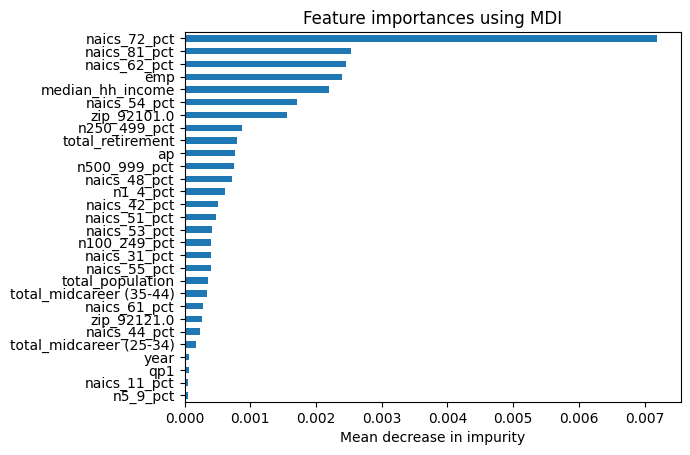

In [47]:
feature_names = short_lagged_ohe_data_train.columns.drop(['est'])

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)[1:30].sort_values(ascending=True)
display(forest_importances.index.to_numpy())

fig, ax = plt.subplots()
forest_importances.plot(kind='barh', ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")

### ARIMA

In [24]:
from statsmodels.tsa.arima.model import ARIMA

class ARIMAForecast():
    
    def __init__(self, data, n_lag_terms ,diff_order ,window_size):
        self.data = data
        self.models = {}
        self.n_lag_terms = n_lag_terms
        self.diff_order = diff_order
        self.window_size = window_size
        
    def train(self):
        for zip_code in self.data['zip'].unique():
            # filter
            curr_data = self.data[self.data['zip']==zip_code][['year', 'est']].set_index('year')
            start_time = curr_data.index[0]
            # train
            model = ARIMA(curr_data, order=(self.n_lag_terms ,self.diff_order ,self.window_size))
            try:
                results = model.fit()
                self.models[zip_code] = (results, start_time)
            except:
                pass
            
    def forecast(self, year):
        preds = []
        # last year seen in the training set
        # used to calculate start range for forecast, to avoid predicting values in training set
        data_last_year = self.data['year'].max()
        for zip_code, model_info in self.models.items():
            model, start_time = model_info
            # make predictions
            curr_pred = model.predict(data_last_year-start_time+1,year-start_time)
            # modify results into a df object
            curr_pred = curr_pred.to_frame().assign(zip=np.full(curr_pred.shape[0], zip_code)).reset_index()
            curr_pred = curr_pred.rename(columns={'index':'year', 0:'est', 'predicted_mean':'est'})
            # address issue where timestamp of some predictions is the number of years after the last year
            # in the training data rather than a timestamp object
            max_int = curr_pred[curr_pred['year'].apply(lambda x: type(x) == int)]['year'].max()
            curr_pred['year'] = curr_pred['year'].apply(lambda x: year-max_int+x if (type(x) == int) else x)
            preds += [curr_pred]
            
        return pd.concat(preds, ignore_index=True).reset_index(drop=True)
            

In [30]:
model = ARIMAForecast(short_data_train, 1, 1, 1)

model.train()

forecast = model.forecast(short_data_test['year'].max())
preds_labels = forecast.merge(short_data_test, on=['zip', 'year'], suffixes=('_pred', '_true'))

mean_squared_error(preds_labels['est_true'], preds_labels['est_pred'], squared=False)

21.86010421984797

In [29]:
model = ARIMAForecast(long_data_train, 1, 1, 1)

model.train()

forecast = model.forecast(long_data_test['year'].max())
preds_labels = forecast.merge(long_data_test, on=['zip', 'year'], suffixes=('_pred', '_true'))

mean_squared_error(preds_labels['est_true'], preds_labels['est_pred'], squared=False)

33.468354257232015